# Inception Module in GoogleNet(Using GPU)
![6QoQY2](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/6QoQY2.png)
![8Doig2](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/8Doig2.png)
![iNwxae](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/iNwxae.png)
- 在Inception Module中初始输入的通道数目没有写死，而是采用变量input_channels表示，成为了__init__构造函数的一个参数


In [9]:
import torch 
from torchvision import transforms 
from torchvision import datasets 
from torch.utils.data import DataLoader 
import torch.nn.functional as F 
import torch.optim as optim
import time
import matplotlib.pyplot as plt

## 1、Prepare Dataset

In [10]:
batch_size = 64

## Convert the PIL Image to Tensor.
transform = transforms.Compose([
    transforms.ToTensor(), # 图像转变为ToTensor，取值变为0-1
    transforms.Normalize((0.1307, ), (0.3081, )) 
    # 0.1307是均值mean, 0.3081是标准差std
    # 这两个数是根据 MNIST数据集的特征得到的经验值
])

## 构造loader
train_dataset = datasets.MNIST(root='./dataset/mnist/', 
                               train=True, 
                               download=True, 
                               transform=transform) # transform放入到了数据集中，这样每次取出来的数据都会直接做变换
train_loader = DataLoader(train_dataset, 
                          shuffle=True, 
                          batch_size=batch_size)
test_dataset = datasets.MNIST(root='./dataset/mnist/' , 
                              train=False, 
                              download=True, 
                              transform=transform)
test_loader = DataLoader(test_dataset, 
                         shuffle=False, 
                         batch_size=batch_size)

## 2、Design CNN Model 
### 2.1 构造Inception Module

In [11]:
## Inception Module
class InceptionA(torch.nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__() 
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        
        self.branch5x5_1 = torch.nn.Conv2d(in_channels,16, kernel_size=1) 
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)
        
        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1) 
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1) 
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)
        
        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):

        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x) 
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3 = self.branch3x3_1(x) 
        branch3x3 = self.branch3x3_2(branch3x3) 
        branch3x3 = self.branch3x3_3(branch3x3)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1) 
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool] 
        return torch.cat(outputs, dim=1)

## 2.2 构造网络结构

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = torch.nn.Conv2d(88, 20, kernel_size=5) 
        
        self.incep1 = InceptionA(in_channels=10) 
        self.incep2 = InceptionA(in_channels=20)
        
        self.mp = torch.nn.MaxPool2d(2) 
        self.fc = torch.nn.Linear(1408, 10) # 88*4*4 = 1408 
    
    def forward(self, x):
        # Flatten data from (n, 1, 28, 28) to (n, 784)
        batch_size = x.size(0) 
        x = F.relu(self.mp(self.conv1(x)))
        x = self.incep1(x)
        x = F.relu(self.mp(self.conv2(x)))
        x = self.incep2(x)
        x = x.view(batch_size, -1) # flatten 
        # print x size
        # print(x.size()) # torch.Size([64, 1408])
        x = self.fc(x)  # 因为后面要用PyTorch的交叉熵函数，因此最后一层不做激活
        return x
    
model = Net()
## Define device as the first visible cuda device if we have CUDA available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
## Convert parameters and buffers of all modules to CUDA Tensor.
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(88, 20, kernel_size=(5, 5), stride=(1, 1))
  (incep1): InceptionA(
    (branch1x1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch_pool): Conv2d(10, 24, kernel_size=(1, 1), stride=(1, 1))
  )
  (incep2): InceptionA(
    (branch1x1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3_1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
   

## 3、Construct Loss and Optimizer

In [13]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # momentum表示动量

## 4、Train & Test

In [14]:
## 将训练过程封装到函数
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data 
        ## Send the inputs and targets at every step to the GPU.
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        
        # forward + backward + update
        outputs = model(inputs) 
        loss = criterion(outputs, target) 
        loss.backward() 
        optimizer.step()
        running_loss += loss.item() 
        
        if batch_idx % 300 == 299: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300)) 
            running_loss = 0.0

In [15]:
## 将测试过程也封装为函数
def test():
    correct = 0 
    total = 0
    with torch.no_grad(): # Test过程中不需要计算梯度，可以使用“with torch.no_grad()”
        for data in test_loader:
            images, labels = data 
            # Send the inputs and targets at every step to the GPU.
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) 
            _, predicted = torch.max(outputs.data, dim=1) # torch.max用来找行中的最大值所在下标 dim1表示沿着第1个维度找（行是第0个维度，列是第1个维度）
            total += labels.size(0) # labels是一个N*1的向量，取size()得到的是元组(N,1),size(0)返回的是N
            correct += (predicted == labels).sum().item() # 预测正确的数量，predicted == labels进行的是张量之间的比较运算
    acc = 100 * correct / total
    print('Accuracy on test set: %d %%' % (acc))
    return acc

## Main Function

In [16]:
epoch_list = []
acc_list = []

In [17]:
if __name__ == '__main__':
    start = time.time()
    for epoch in range(10):
        train(epoch) 
        epoch_list.append(epoch)
        acc_list.append(test())
    end = time.time()
    print("Total time: ", end - start , "s")

[1,   300] loss: 0.971
[1,   600] loss: 0.210
[1,   900] loss: 0.151
Accuracy on test set: 96 %
[2,   300] loss: 0.118
[2,   600] loss: 0.108
[2,   900] loss: 0.093
Accuracy on test set: 97 %
[3,   300] loss: 0.082
[3,   600] loss: 0.084
[3,   900] loss: 0.073
Accuracy on test set: 97 %
[4,   300] loss: 0.068
[4,   600] loss: 0.070
[4,   900] loss: 0.063
Accuracy on test set: 98 %
[5,   300] loss: 0.063
[5,   600] loss: 0.058
[5,   900] loss: 0.054
Accuracy on test set: 98 %
[6,   300] loss: 0.052
[6,   600] loss: 0.054
[6,   900] loss: 0.049
Accuracy on test set: 98 %
[7,   300] loss: 0.049
[7,   600] loss: 0.044
[7,   900] loss: 0.048
Accuracy on test set: 98 %
[8,   300] loss: 0.040
[8,   600] loss: 0.046
[8,   900] loss: 0.043
Accuracy on test set: 98 %
[9,   300] loss: 0.035
[9,   600] loss: 0.043
[9,   900] loss: 0.042
Accuracy on test set: 98 %
[10,   300] loss: 0.036
[10,   600] loss: 0.039
[10,   900] loss: 0.035
Accuracy on test set: 98 %
Total time:  121.382563829422 s


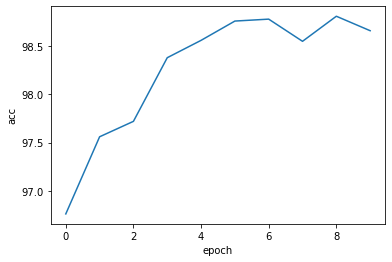

In [18]:
# plot
plt.plot(epoch_list, acc_list) 
plt.xlabel('epoch') 
plt.ylabel('acc')
plt.show()